## 1. Importing Libraries & Load the file

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Reading Dataset
data = pd.read_csv('/content/drive/MyDrive/FacialExpressionDetection/fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
1,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
2,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
3,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
4,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest
5,0,138 142 66 80 87 92 97 99 88 73 72 83 92 102 1...,PrivateTest
6,4,72 66 66 69 62 51 57 60 56 66 63 70 68 68 81 9...,PrivateTest
7,3,4 4 7 12 14 18 26 31 33 38 44 49 59 68 80 86 9...,PrivateTest
8,0,245 245 239 122 144 101 33 37 84 137 143 130 1...,PrivateTest
9,3,20 31 65 81 79 63 61 51 61 97 114 121 140 200 ...,PrivateTest


In [3]:
# Checking Shape of data
data.shape

(3589, 3)

## 2. Data Visualization

In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

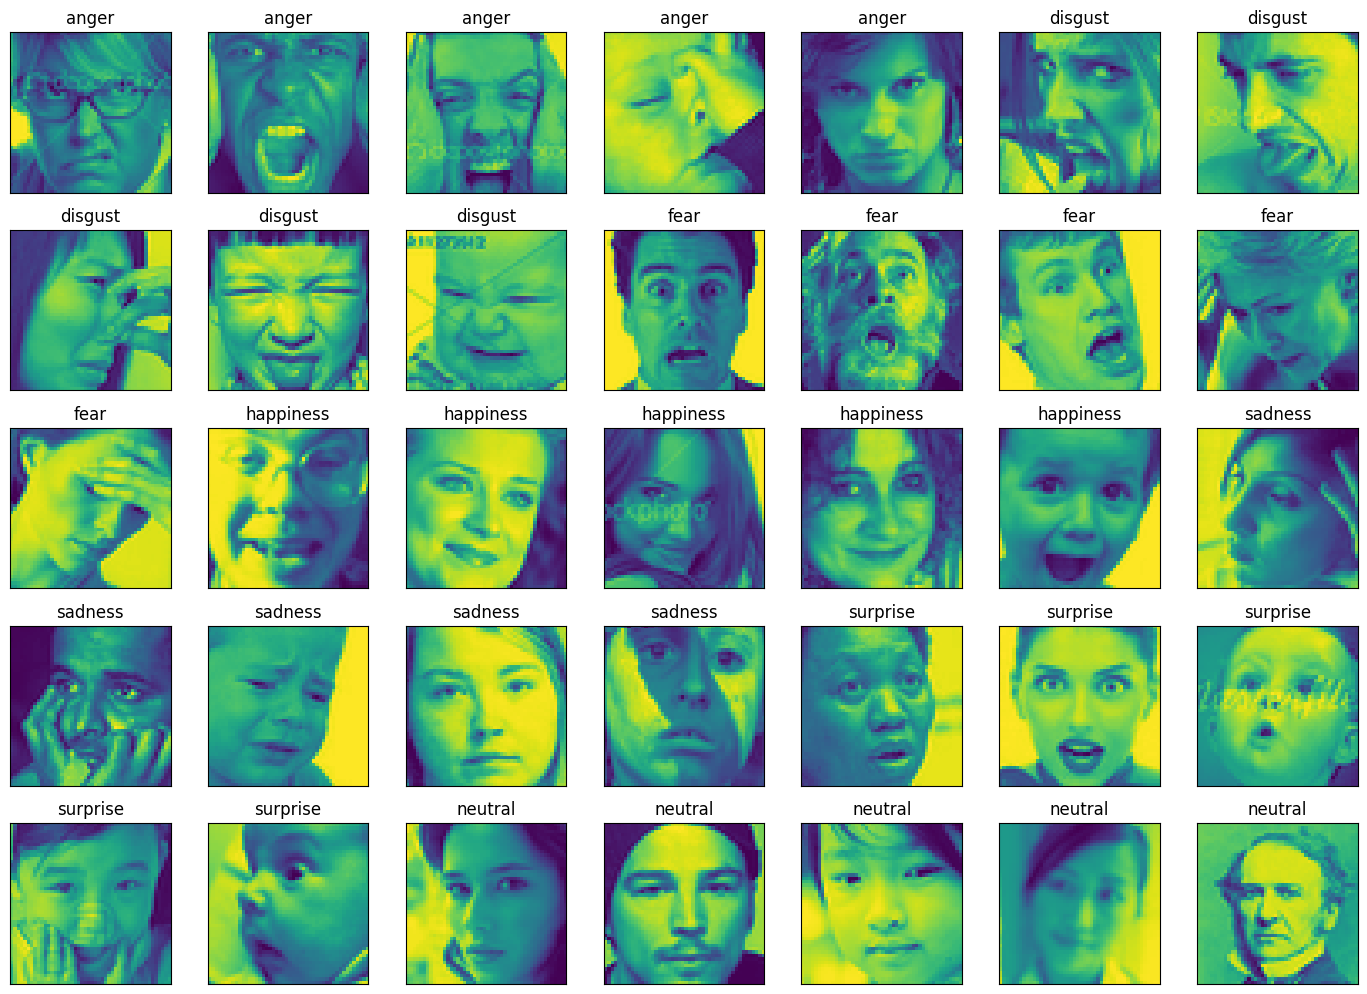

In [5]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [6]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

,count
emotion,
3,879
6,626
4,594
2,528
0,491
5,416
1,55


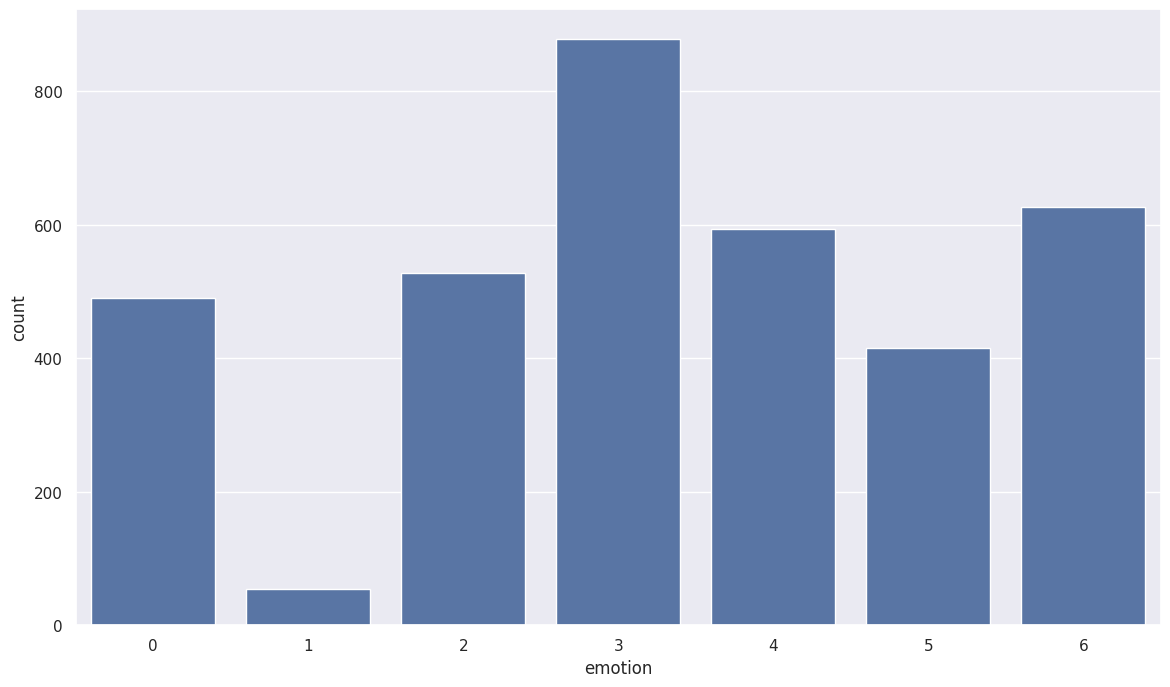

In [7]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

*From the above chart, we can observe that the data is highly imbalnace and for some emotions we have very small number of images, so we need to balnce the data by oversampling technique, so to that enough number of images for every emotions(class).*

## 3. Data Pre-processing (Balancing & Preparation)

In [8]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [9]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(6153, 1)   (6153,)


In [10]:
# Let's check the distributio of target data again after balancing
y_data.value_counts()

,count
emotion,
0,879
5,879
6,879
4,879
2,879
3,879
1,879


In [11]:
x_data = pd.Series(x_data.flatten())
x_data

,0
0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
1,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
2,232 240 241 239 237 235 246 117 24 24 22 13 12...
3,200 197 149 139 156 89 111 58 62 95 113 117 11...
4,40 28 33 56 45 33 31 78 152 194 200 186 196 20...
...,...
6148,121 158 143 28 22 19 18 14 14 17 19 23 31 47 5...
6149,4 4 4 4 4 4 4 5 1 6 16 27 52 62 67 78 88 93 96...
6150,68 36 45 62 80 76 87 103 125 227 137 158 174 1...
6151,212 212 213 213 213 214 198 158 89 58 42 56 16...


In [12]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.6666667 , 0.4627451 , 0.39607844, ..., 0.62352943, 0.52156866,
        0.5137255 ],
       [0.02745098, 0.01960784, 0.03137255, ..., 0.28235295, 0.22352941,
        0.20392157],
       [0.9098039 , 0.9411765 , 0.94509804, ..., 0.01568628, 0.01568628,
        0.03529412],
       ...,
       [0.01568628, 0.01568628, 0.02745098, ..., 0.16470589, 0.19215687,
        0.21176471],
       [0.9607843 , 0.9607843 , 0.9372549 , ..., 0.45882353, 0.4509804 ,
        0.40784314],
       [0.07843138, 0.12156863, 0.25490198, ..., 0.03921569, 0.07058824,
        0.03137255]], dtype=float32)

In [13]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(6153, 48, 48, 1)

In [14]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(6153, 1)

In [15]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [16]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5537, 48, 48, 1), (616, 48, 48, 1), (5537, 1), (616, 1))

In [17]:
# Perform One-Hot Encoding on training data
y_train = to_categorical(y_train, 7)
y_train.shape

(5537, 7)

In [18]:
# Perform One-Hot Encoding on test data
y_test = to_categorical(y_test, 7)
y_test.shape

(616, 7)

## 4. Model Building

In [19]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │              

 Total params: 792,855 (3.02 MB)

 Trainable params: 792,023 (3.02 MB)

 Non-trainable params: 832 (3.25 KB)

## 5. Model Training

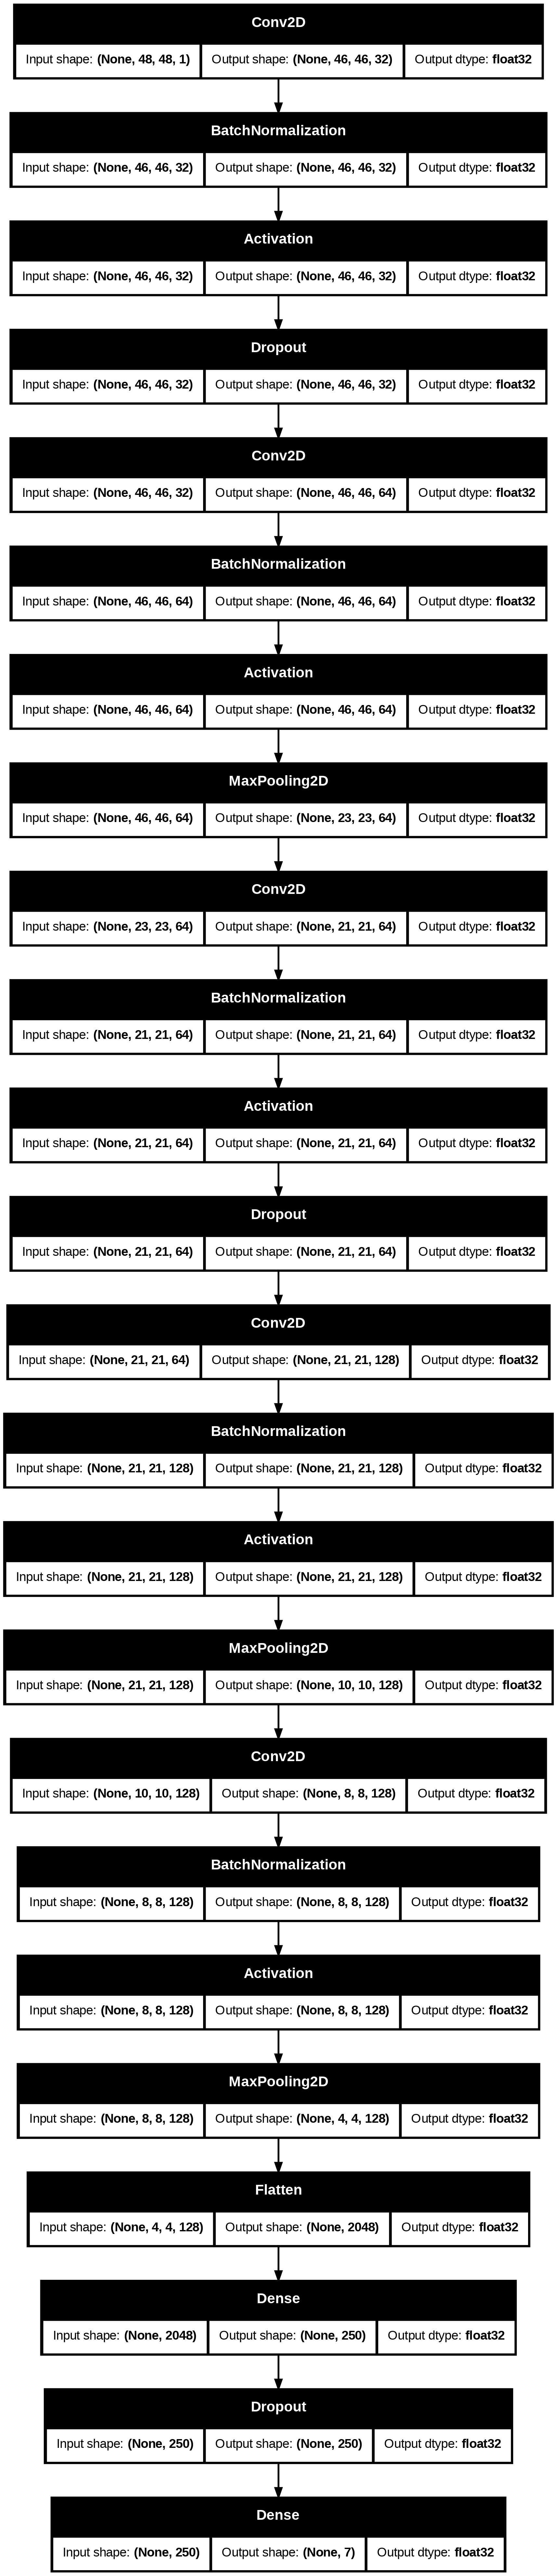

In [21]:
# Model Flowchart
tf.keras.utils.plot_model(model, to_file = "/content/drive/MyDrive/FacialExpressionDetection/best_model.png", show_shapes = True, show_dtype = True)

In [22]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 2, validation_data=(x_test, y_test))

Epoch 1/3
174/174 ━━━━━━━━━━━━━━━━━━━━ 143s 818ms/step - accuracy: 0.2647 - loss: 1.8274 - val_accuracy: 0.1575 - val_loss: 2.0144
Epoch 2/3
174/174 ━━━━━━━━━━━━━━━━━━━━ 188s 741ms/step - accuracy: 0.3128 - loss: 1.7615 - val_accuracy: 0.1753 - val_loss: 1.9057
Epoch 3/3
174/174 ━━━━━━━━━━━━━━━━━━━━ 143s 749ms/step - accuracy: 0.3528 - loss: 1.6934 - val_accuracy: 0.2760 - val_loss: 1.7606


## 6. Model Evaluation

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.2491 - loss: 1.7825
Accuracy of our model on test data :  27.597403526306152 %
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.2491 - loss: 1.7825
Loss of our model on test data :  1.7605503797531128


***The test accuracy & loss of our model is 81.31% & 0.605 respectively, which is better than many exsited state-of-the-art results.***

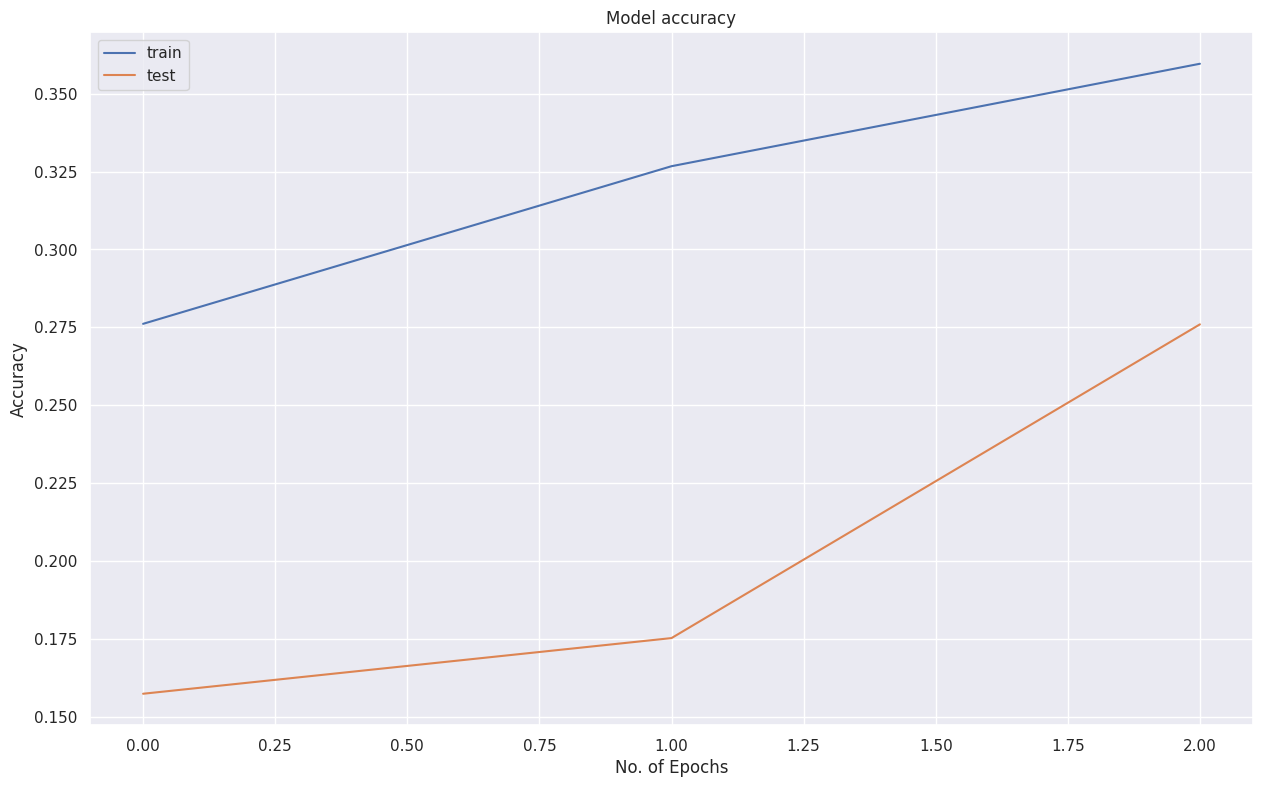

In [26]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

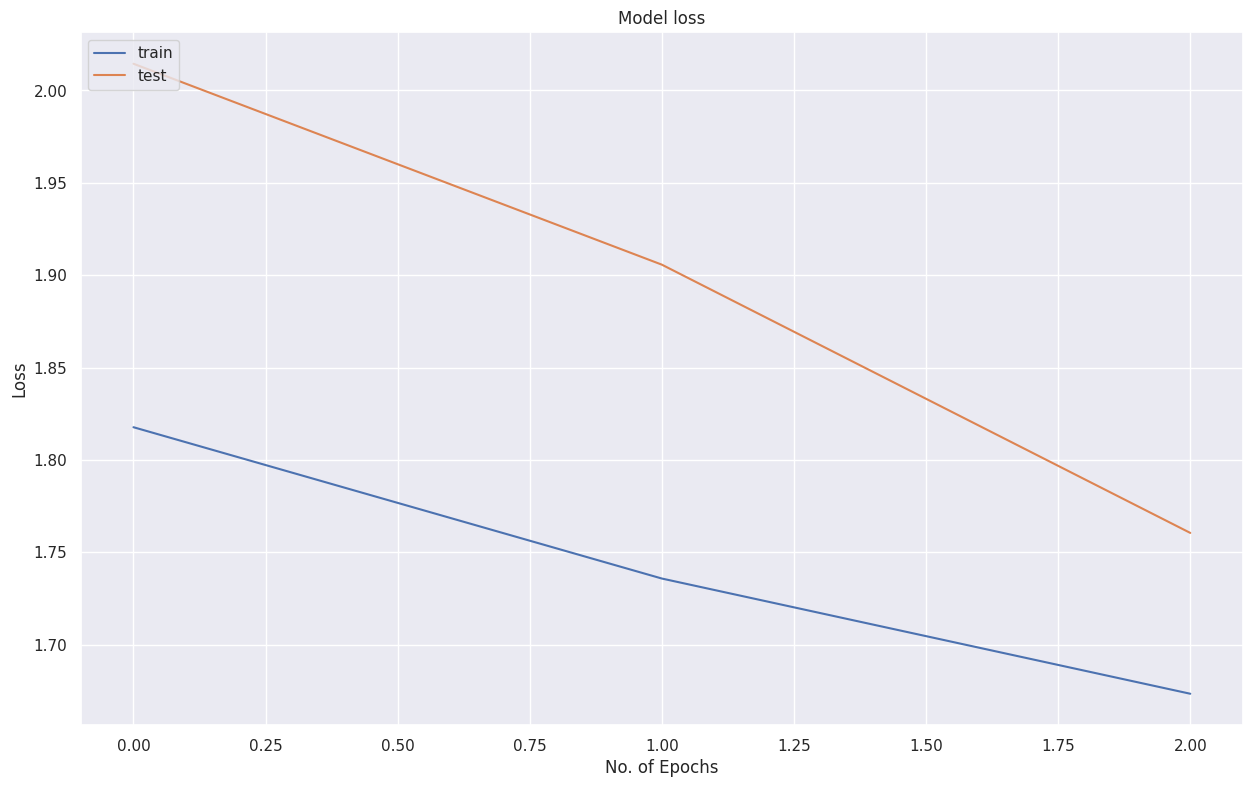

In [27]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7. Getting Classification Report & Plotting Confusion Matrix

In [28]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step


[6, 6, 3, 3, 3, 3, 3, 3, 3, 6]

In [29]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 3, 2, 4, 4, 5, 5, 2, 0, 0]

In [30]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.75      0.04      0.07        79
           1       0.51      0.52      0.51        83
           2       0.33      0.01      0.02       101
           3       0.19      0.71      0.30        87
           4       0.37      0.15      0.21        94
           5       0.51      0.29      0.37        82
           6       0.21      0.26      0.23        90

    accuracy                           0.28       616
   macro avg       0.41      0.28      0.25       616
weighted avg       0.40      0.28      0.24       616



Text(178.75, 0.5, 'Truth')

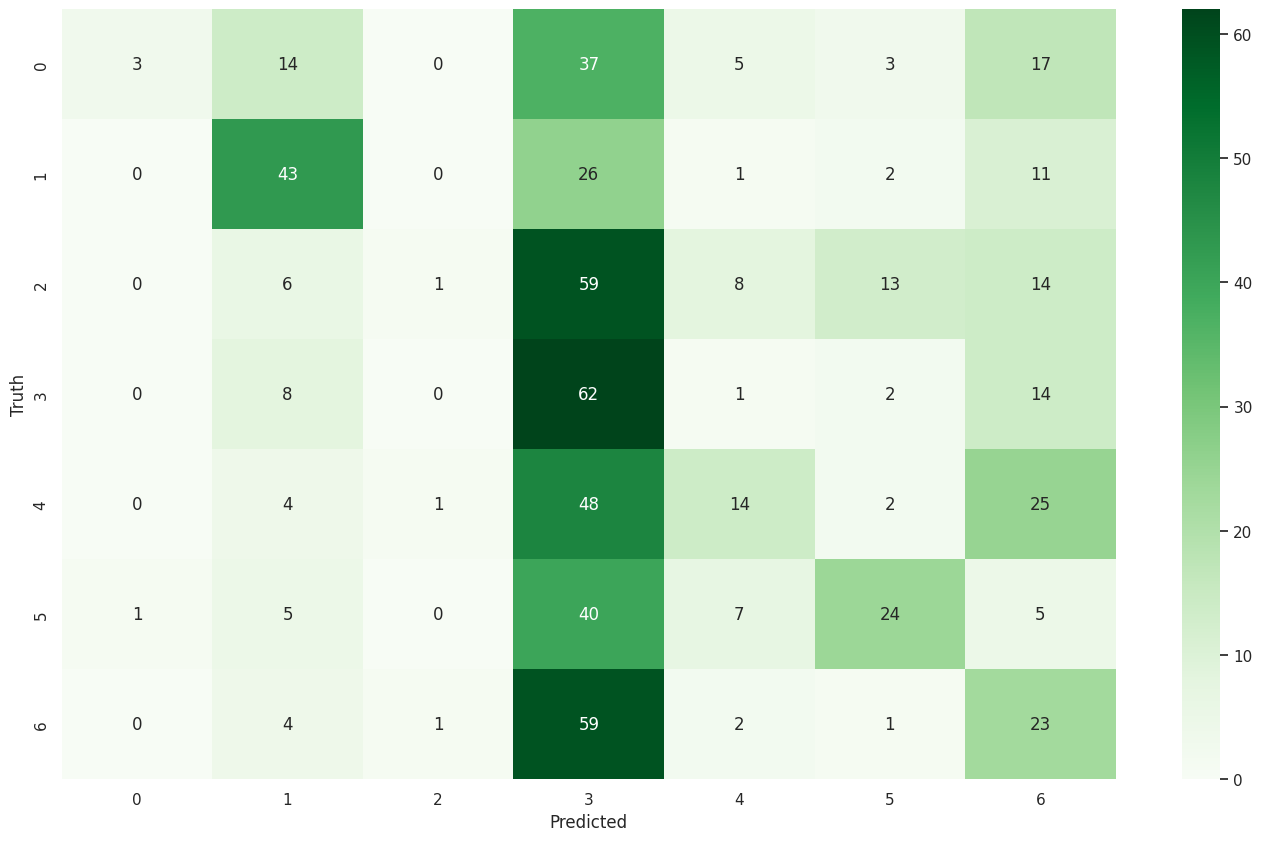

In [31]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **8. Save the Model**

In [32]:
# Save the Model
model.save("/content/drive/MyDrive/FacialExpressionDetection/Facial_Expression_Detection_System.keras")

In [33]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("/content/drive/MyDrive/FacialExpressionDetection/Facial Expression Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.weights.h5")

## **9. Making Prediction in a Real-Time**

Model loaded successfully.


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predicted Emotion: disgust


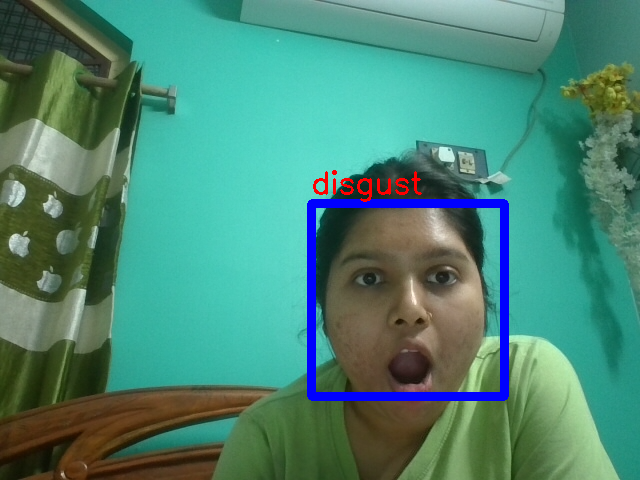

In [17]:
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import base64
from io import BytesIO

# Load the model
model_json_path = "/content/drive/MyDrive/FacialExpressionDetection/Facial Expression Recognition.json"
model_weights_path = "/content/drive/MyDrive/FacialExpressionDetection/fer.weights.h5"

with open(model_json_path, "r") as json_file:
    model = model_from_json(json_file.read())

model.load_weights('fer.weights.h5')
print("Model loaded successfully.")

# Load Haar Cascade
cascade_path = "/content/drive/MyDrive/FacialExpressionDetection/haarcascade_frontalface_default.xml"
face_haar_cascade = cv2.CascadeClassifier(cascade_path)

# JavaScript to show webcam and capture image
def show_webcam():
    display(Javascript('''
        async function showWebcam() {
            const video = document.createElement('video');
            video.style.display = 'block';
            document.body.appendChild(video);

            // Request webcam access
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            const button = document.createElement('button');
            button.innerText = 'Capture Image';
            document.body.appendChild(button);

            button.onclick = () => {
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                const dataURL = canvas.toDataURL('image/png');
                stream.getTracks().forEach(track => track.stop());
                video.remove();
                canvas.remove();
                button.remove();

                // Send image data to Python
                google.colab.kernel.invokeFunction('notebook.captureImage', [dataURL], {});
            };
        }
        showWebcam();
    '''))

# Callback function to receive image data
def capture_image(data):
    # Decode the base64 image data
    image_data = data.split(',')[1]
    image_bytes = BytesIO(base64.b64decode(image_data))
    photo = Image.open(image_bytes)

    # Process the image
    process_image(photo)

# Register the callback
from google.colab import output
output.register_callback('notebook.captureImage', capture_image)

# Process the captured image
def process_image(image_pil):
    img = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces_detected) == 0:
        print("No face detected.")
        return

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 7)

        # Preprocess the region of interest (ROI)
        roi_gray = gray_img[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255.0

        # Predict the emotion
        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]
        print("Predicted Emotion:", predicted_emotion)

        # Add text to the image
        cv2.putText(img, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Display the processed image
    cv2_imshow(img)

# Main Execution
show_webcam()
